### Authors:

Marek Szydłowski 136633<br>
Wojciech Tomczak 145467

Link to the source code: https://github.com/Vosloo/evolutionary-computation-labs

In [1]:
from copy import deepcopy
from dataclasses import dataclass
from random import choice, sample
from statistics import mean
from time import perf_counter
from typing import Callable

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

plt.rcParams["figure.figsize"] = (16, 12)
sns.set_theme(style="darkgrid")

<center><h2><a href=#results>Click here for results</a></h2></center>

In [2]:
df_a = pd.read_csv("data/TSPA.csv", sep=";", header=None, names=["x", "y", "cost"])
df_b = pd.read_csv("data/TSPB.csv", sep=";", header=None, names=["x", "y", "cost"])

In [3]:
df_a

,x,y,cost
0,1510,353,84
1,3042,123,483
2,2145,389,1462
3,1030,365,1986
4,2125,360,145
...,...,...,...
195,1023,1258,197
196,3192,1271,1183
197,3735,1879,1461
198,3983,299,1309


In [4]:
df_b

,x,y,cost
0,2907,1115,928
1,3433,183,1864
2,2237,74,260
3,91,583,1006
4,3053,1867,993
...,...,...,...
195,1252,970,1882
196,613,784,439
197,3139,470,597
198,2465,1165,570


In [5]:
class Node:
    def __init__(self, id, x, y, cost) -> None:
        self.id = id
        self.x = x
        self.y = y
        self.cost = cost
        self.connections: list[Node] = []

    def add_connection(self, node: "Node") -> None:
        self.connections.append(node)
        node.connections.append(self)

    def remove_connection(self, node: "Node") -> None:
        self.connections.remove(node)
        node.connections.remove(self)

    def __eq__(self, o: object) -> bool:
        if isinstance(o, Node):
            return self.id == o.id

        return False

    def __hash__(self) -> int:
        return self.id

    def __repr__(self) -> str:
        return str(self.id)

    def __str__(self) -> str:
        return str(self.id)

In [6]:
def get_distance_matrix(A: np.array) -> np.array:
    p1 = np.sum(A**2, axis=1)[:, np.newaxis]
    p2 = np.sum(A**2, axis=1)
    p3 = -2 * np.dot(A, A.T)
    return np.array(np.sqrt(p1 + p2 + p3)).astype(int)


def _get_nearest_node(
    pivot_node: Node, unselected_nodes: list[Node], distance_matrix: np.array
) -> Node:
    min_distance = float("inf")
    min_node = None
    for node in unselected_nodes:
        distance = distance_matrix[pivot_node.id, node.id] + node.cost

        if distance < min_distance:
            min_distance = distance
            min_node = node

    return min_node

In [7]:
def _get_edges(selected_nodes: list[Node]) -> list[tuple[Node, Node]]:
    edges = []
    visited_nodes = set()
    for selected_node in selected_nodes:
        for connection in selected_node.connections:
            if connection not in visited_nodes:
                edges.append((selected_node, connection))

        visited_nodes.add(selected_node)

    return edges


def _nodes_to_seq(nodes: list[Node]) -> list[Node]:
    cur_node = nodes[0]
    seq = [cur_node]
    while True:

        for connection in cur_node.connections:
            if connection in seq:
                continue

            seq.append(connection)
            cur_node = connection
            break

        if len(seq) == len(nodes):
            break

    return seq

In [8]:
def random(pivot_node: Node, nodes: list[Node], k: int, distance_matrix, *args) -> list[Node]:
    return sample(nodes, k)

In [9]:
def nearest(pivot_node: Node, nodes: list[Node], k: int, distance_matrix, *args) -> list[Node]:
    nodes_set = set(nodes)
    selected_nodes = [pivot_node]

    for _ in range(k - 1):
        cur_node = selected_nodes[-1]
        unselected_nodes = nodes_set - set(selected_nodes)

        min_node = _get_nearest_node(cur_node, unselected_nodes, distance_matrix)

        selected_nodes.append(min_node)

    return selected_nodes

In [10]:
def greedy_cycle(pivot_node: Node, nodes: list[Node], k: int, distance_matrix, *args) -> list[Node]:
    nodes_set = set(nodes)

    selected_nodes = [pivot_node]
    min_node = _get_nearest_node(pivot_node, set(nodes) - set(selected_nodes), distance_matrix)

    pivot_node.add_connection(min_node)
    selected_nodes.append(min_node)

    anchor_nodes = []
    for _ in range(k - 2):
        min_distance = float("inf")
        min_node = None
        edges = _get_edges(selected_nodes)

        possible_nodes = nodes_set - set(selected_nodes)
        for node in possible_nodes:
            for edge in edges:
                anchor_1, anchor_2 = edge
                distance = (
                    distance_matrix[anchor_1.id][node.id]
                    + distance_matrix[anchor_2.id][node.id]
                    + node.cost
                    - distance_matrix[anchor_1.id][anchor_2.id]
                )

                if distance < min_distance:
                    min_distance = distance
                    min_node = node
                    anchor_nodes = [anchor_1, anchor_2]

        anchor_1, anchor_2 = anchor_nodes
        if len(selected_nodes) > 2:
            anchor_1.remove_connection(anchor_2)

        anchor_1.add_connection(min_node)
        anchor_2.add_connection(min_node)

        selected_nodes.append(min_node)

    return _nodes_to_seq(selected_nodes)

```
algorithm greedy_k_regret is
   input: Pivot node p,
          List of nodes N,
          Number of nodes to select n,
          Distance matrix D,
          k-regret k
   output: Selected nodes S

   S := [p]

   for i := 0 in 2
      p := S[-1]
      min_node := nearest_neighbour(p, N - S, D)

      S := S + min_node

   for i := 0 in n - 2
      edges := edges in S
      PN := N - S

      nodes_distances := matrix of distances from every node in PN to every edge in edges

      sorted_nodes_distances := nodes_distances sorted on delta change from node to edges

      regrets := first column of sorted_nodes_distances subtracted by second column

      chosen_node_idx := argmin{regrets}
      chosen_node := node in PN at chosen_node_idx

      S := S + chosen_node

   return S
```

In [11]:
def _get_greedy_distance(node: Node, edge: tuple[Node, Node], distance_matrix: np.array) -> int:
    a, b = edge
    return (
        distance_matrix[node.id, a.id]
        + distance_matrix[node.id, b.id]
        - distance_matrix[a.id, b.id]
        + node.cost
    )


def greedy_k_regret(
    pivot_node: Node, nodes: list[Node], n: int, distance_matrix: np.array, k_regret: int, *args
) -> list[Node]:
    nodes_set = set(nodes)

    selected_nodes = [pivot_node]

    # We need three nodes so that regret can be calculated
    for _ in range(2):
        pivot_node = selected_nodes[-1]
        min_node = _get_nearest_node(pivot_node, set(nodes) - set(selected_nodes), distance_matrix)

        pivot_node.add_connection(min_node)
        selected_nodes.append(min_node)

    anchor_nodes = []
    for _ in range(n - len(selected_nodes)):
        min_distance = float("inf")
        min_node = None
        edges = _get_edges(selected_nodes)

        possible_nodes = nodes_set - set(selected_nodes)
        nodes_distances = np.array(
            [
                [_get_greedy_distance(node, edge, distance_matrix) for edge in edges]
                for node in possible_nodes
            ]
        )

        nodes_distances_edges = np.argsort(nodes_distances, axis=1)
        nodes_distances = np.take_along_axis(nodes_distances, nodes_distances_edges, axis=1)
        k_best = nodes_distances[:, :k_regret]

        regrets = k_best[:, 0] - k_best[:, 1]

        chosen_ind = np.argmin(regrets)
        chosen_edge_ind = nodes_distances_edges[chosen_ind, 0]

        min_node = list(possible_nodes)[chosen_ind]
        anchor_1, anchor_2 = edges[chosen_edge_ind]

        if len(selected_nodes) > 2:
            anchor_1.remove_connection(anchor_2)

        anchor_1.add_connection(min_node)
        anchor_2.add_connection(min_node)

        selected_nodes.append(min_node)

    return _nodes_to_seq(selected_nodes)

```
algorithm greedy_regret_weighted is
   input: Pivot node p,
          List of nodes N,
          Number of nodes to select n,
          Distance matrix D,
          k-regret k
          regrets_weight rw
          delta_weight dw
          
   output: Selected nodes S

   S := [p]

   for i := 0 in 2
      p := S[-1]
      min_node := nearest_neighbour(p, N - S, D)

      S := S + min_node

   for i := 0 in n - 2
      edges := edges in S
      PN := N - S

      nodes_distances := matrix of distances from every node in PN to every edge in edges

      sorted_nodes_distances := nodes_distances sorted on delta change from node to edges

      regrets := first column of sorted_nodes_distances subtracted by second column

      scores := regrets * rw + (first column of sorted_nodes_distances) * dw

      chosen_node_idx := argmin{scores}
      chosen_node := node in PN at chosen_node_idx

      S := S + chosen_node

   return S
```

In [12]:
def greedy_regret_weighted(
    pivot_node: Node,
    nodes: list[Node],
    n: int,
    distance_matrix: np.array,
    k_regret: int,
    regret_weight: float = 0.5,
    greedy_weight: float = 0.5,
) -> list[Node]:
    nodes_set = set(nodes)

    selected_nodes = [pivot_node]

    # We need three nodes so that regret can be calculated
    for _ in range(2):
        pivot_node = selected_nodes[-1]
        min_node = _get_nearest_node(pivot_node, set(nodes) - set(selected_nodes), distance_matrix)

        pivot_node.add_connection(min_node)
        selected_nodes.append(min_node)

    anchor_nodes = []
    for _ in range(n - len(selected_nodes)):
        min_distance = float("inf")
        min_node = None
        edges = _get_edges(selected_nodes)

        possible_nodes = nodes_set - set(selected_nodes)
        nodes_distances = np.array(
            [
                [_get_greedy_distance(node, edge, distance_matrix) for edge in edges]
                for node in possible_nodes
            ]
        )

        nodes_distances_edges = np.argsort(nodes_distances, axis=1)
        nodes_distances = np.take_along_axis(nodes_distances, nodes_distances_edges, axis=1)
        k_best = nodes_distances[:, :k_regret]

        regrets = k_best[:, 0] - k_best[:, 1]

        weighted_scores = (regrets * regret_weight) + (greedy_weight * k_best[:, 0])

        # get real index of the best node and edge
        chosen_ind = np.argmin(weighted_scores)
        chosen_edge_ind = nodes_distances_edges[chosen_ind, 0]

        min_node = list(possible_nodes)[chosen_ind]
        anchor_1, anchor_2 = edges[chosen_edge_ind]

        if len(selected_nodes) > 2:
            anchor_1.remove_connection(anchor_2)

        anchor_1.add_connection(min_node)
        anchor_2.add_connection(min_node)

        selected_nodes.append(min_node)

    return _nodes_to_seq(selected_nodes)

In [13]:
@dataclass
class Run:
    def __init__(self, id: int, nodes: list[Node], cost: int, distance: int) -> None:
        self.id: int = id
        self.nodes: list[Node] = nodes
        self.cost: int = cost
        self.distance: int = distance

    @property
    def score(self) -> int:
        return self.cost + self.distance

    def __repr__(self) -> str:
        return f"Run(id={self.id}, cost={self.cost}, distance={self.distance})"


@dataclass
class Grade:
    def __init__(
        self, method_name: str, best_run: Run, runs: list[Run]
    ) -> None:  # res: list[tuple[int, int]]
        self.method_name = method_name
        self.best_run: Run = best_run
        self.runs = runs

        scores = [run.score for run in runs]
        self.min: float = min(scores)
        self.max: float = max(scores)
        self.avg: float = mean(scores)

    def __repr__(self) -> str:
        return (
            f"\n{' Grade ':=^80}"
            f"\n{'Method:':<40}{self.method_name}"
            f"\n{'Best run id:':<40}{self.best_run.id}"
            f"\n{'Best run cost:':<40}{self.best_run.cost}"
            f"\n{'Best run distance:':<40}{self.best_run.distance}"
            f"\n{'Best run score:':<40}{self.best_run.score}"
            f"\n{'Min score:':<40}{self.min}"
            f"\n{'Avg score:':<40}{self.avg}"
            f"\n{'Max score:':<40}{self.max}"
            f"\n{'':=^80}\n"
        )

In [14]:
def hex_to_RGB(hex: str) -> list[int]:
    return [int(hex[i : i + 2], 16) for i in range(1, 6, 2)]


def RGB_to_hex(RGB: list[int]) -> str:
    RGB = [int(x) for x in RGB]
    return "#" + "".join(["0{0:x}".format(v) if v < 16 else "{0:x}".format(v) for v in RGB])


def create_linear_gradient(
    start_hex: str = "#FF0000", end_hex: str = "#00FF00", n: int = 10
) -> list[str]:
    s = hex_to_RGB(start_hex)
    f = hex_to_RGB(end_hex)
    gradient = [start_hex]
    for t in range(1, n):
        curr_vector = [int(s[j] + (float(t) / (n - 1)) * (f[j] - s[j])) for j in range(3)]
        gradient.append(RGB_to_hex(curr_vector))

    return gradient


def map_linear_gradient(nodes: list[Node]) -> list[str]:
    min_cost = min(nodes, key=lambda x: x.cost).cost
    gradient = create_linear_gradient(
        start_hex="#C6EA8D", end_hex="#FE90AF", n=max(nodes, key=lambda x: x.cost).cost - min_cost + 1
    )

    return [gradient[node.cost - min_cost] for node in nodes]

In [15]:
def visualise_solution(nodes: list[Node], method_name: str) -> None:
    G = nx.Graph()

    for node in nodes:
        G.add_node(node, pos=(node.x, node.y), size=node.cost)

    for i in range(len(nodes) - 1):
        G.add_edge(nodes[i], nodes[i + 1])

    G.add_edge(nodes[-1], nodes[0])

    pos = nx.get_node_attributes(G, "pos")

    # Add node colors from gradient adding legend
    node_colors = map_linear_gradient(nodes)

    # Normalize node sizes from 200 to 1000
    node_sizes = [node.cost for node in nodes]
    node_sizes = [
        200 + (1000 - 200) * ((node_size - min(node_sizes)) / (max(node_sizes) - min(node_sizes)))
        for node_size in node_sizes
    ]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

    plt.title(f"{method_name.capitalize()} method")
    plt.show()

In [16]:
def plot_grades(grades: list[Grade]) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

    for method_name, grade in grades.items():
        ax1.plot([run.id for run in grade.runs], [run.cost for run in grade.runs], label=method_name)
        ax2.plot(
            [run.id for run in grade.runs], [run.distance for run in grade.runs], label=method_name
        )
        ax3.plot(
            [run.id for run in grade.runs],
            [run.cost + run.distance for run in grade.runs],
            label=method_name,
        )

        ax1.scatter(
            grade.best_run.id,
            grade.best_run.cost,
            color=ax1.lines[-1].get_color(),
            label=f"{method_name} best run",
        )
        ax2.scatter(
            grade.best_run.id,
            grade.best_run.distance,
            color=ax2.lines[-1].get_color(),
            label=f"{method_name} best run",
        )
        ax3.scatter(
            grade.best_run.id,
            grade.best_run.cost + grade.best_run.distance,
            color=ax3.lines[-1].get_color(),
            label=f"{method_name} best run",
        )

    ax1.set_title("Cost")
    ax2.set_title("Distance")
    ax3.set_title("Score")

    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()


def grade_method(
    og_nodes: list[Node], method: Callable, k_regret: int, no_runs: int, distance_matrix: np.array
) -> Grade:
    runs = []
    best_run = None
    best_run_score = float("inf")

    for pivot_ind in range(no_runs):
        print(f"\r{pivot_ind + 1:3} / {no_runs:3}", end="")
        nodes_cp = deepcopy(og_nodes)
        pivot_node = nodes_cp[pivot_ind]

        selected_nodes = method(
            pivot_node, nodes_cp, round(len(nodes_cp) / 2), distance_matrix, k_regret
        )

        total_cost = sum(node.cost for node in selected_nodes)
        total_distance = sum(
            distance_matrix[node.id, selected_nodes[i + 1].id]
            for i, node in enumerate(selected_nodes[:-1])
        )

        curr_run = Run(pivot_ind, selected_nodes, total_cost, total_distance)
        runs.append(curr_run)

        if best_run_score > curr_run.score:
            best_run = Run(pivot_ind, selected_nodes, total_cost, total_distance)
            best_run_score = curr_run.score

    return Grade(method.__name__, best_run, runs)


def grade_dataset(df: pd.DataFrame):
    nodes = [Node(i, x, y, cost) for i, (x, y, cost) in enumerate(zip(df.x, df.y, df.cost))]

    distances = df[["x", "y"]].to_numpy()
    distance_matrix = get_distance_matrix(distances)

    grades: dict[str, Grade] = {}
    no_runs = len(nodes)
    k_regret = 2

    for method in [random, nearest, greedy_cycle, greedy_k_regret, greedy_regret_weighted]:
        method_name = method.__name__
        print(f"Running {method_name} method for {no_runs} runs")
        start = perf_counter()
        grades[method_name] = grade_method(nodes, method, k_regret, no_runs, distance_matrix)
        print(f"\rFinished {method_name} method in {perf_counter() - start:.2f}s")

    for method_name, grade in grades.items():
        print(grade)

    for method_name, grade in grades.items():
        visualise_solution(grade.best_run.nodes, method_name)

    plot_grades(grades)

<center> <h2> Results </h2> </center>

<a id='results'></a>

Running random method for 200 runs
Finished random method in 0.33s
Running nearest method for 200 runs
Finished nearest method in 0.90s
Running greedy_cycle method for 200 runs
Finished greedy_cycle method in 80.24s
Running greedy_k_regret method for 200 runs
Finished greedy_k_regret method in 63.91s
Running greedy_regret_weighted method for 200 runs
Finished greedy_regret_weighted method in 63.68s

==================================== Grade =====================================
Method:                                 random
Best run id:                            144
Best run cost:                          95102
Best run distance:                      137495
Best run score:                         232597
Min score:                              232597
Avg score:                              262805
Max score:                              286770


==================================== Grade =====================================
Method:                                 nearest
Best run id: 

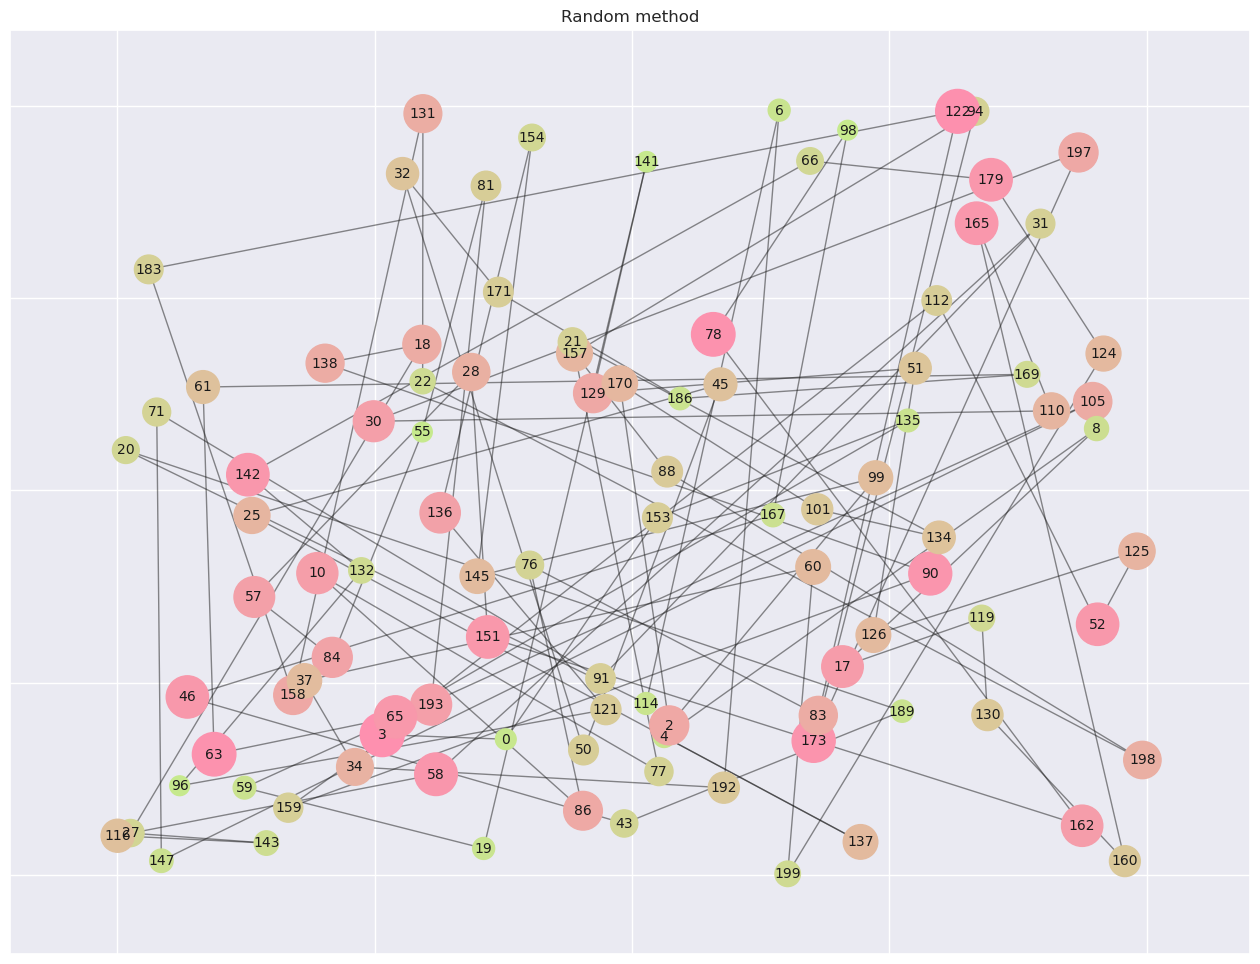

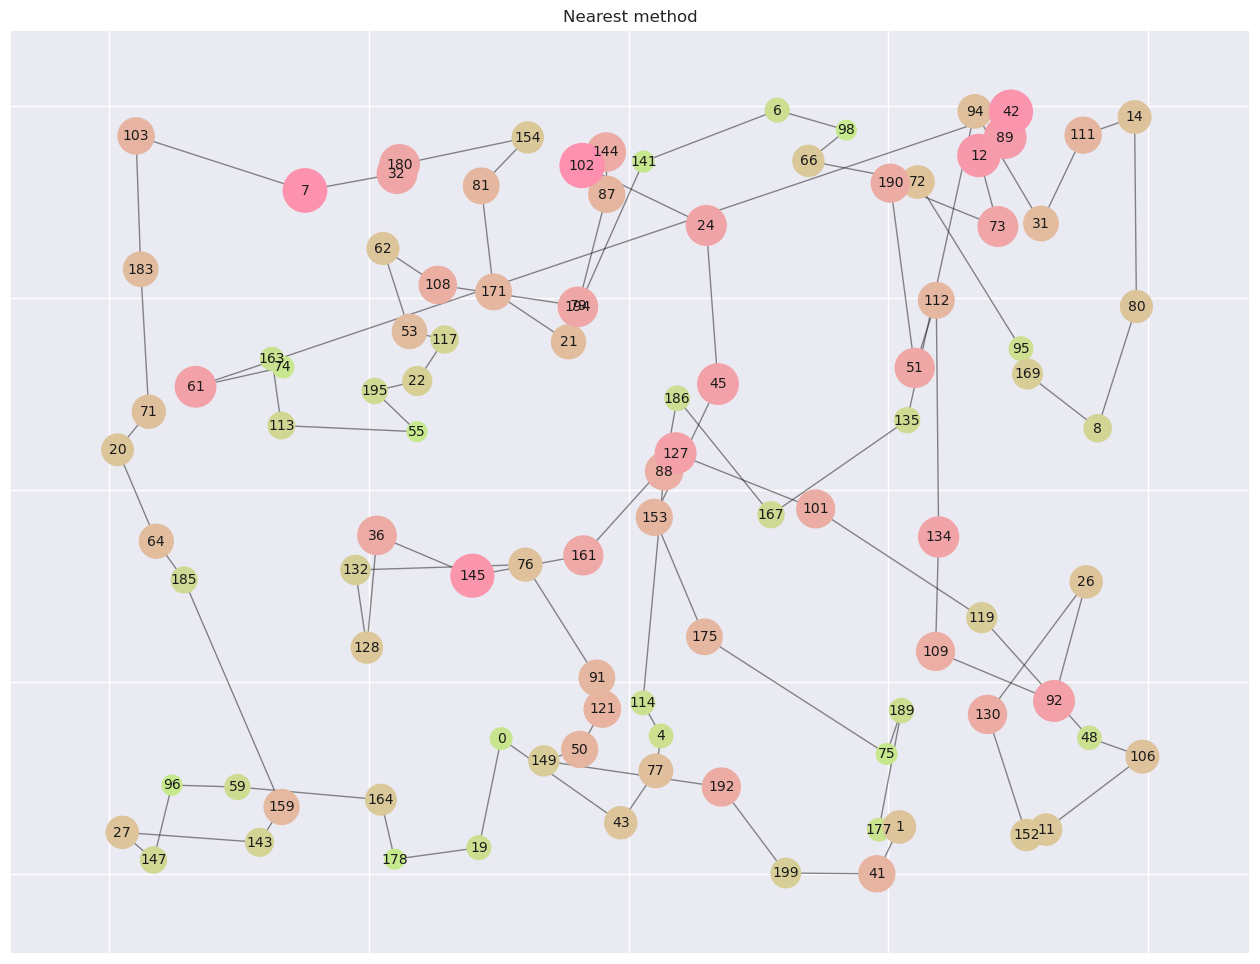

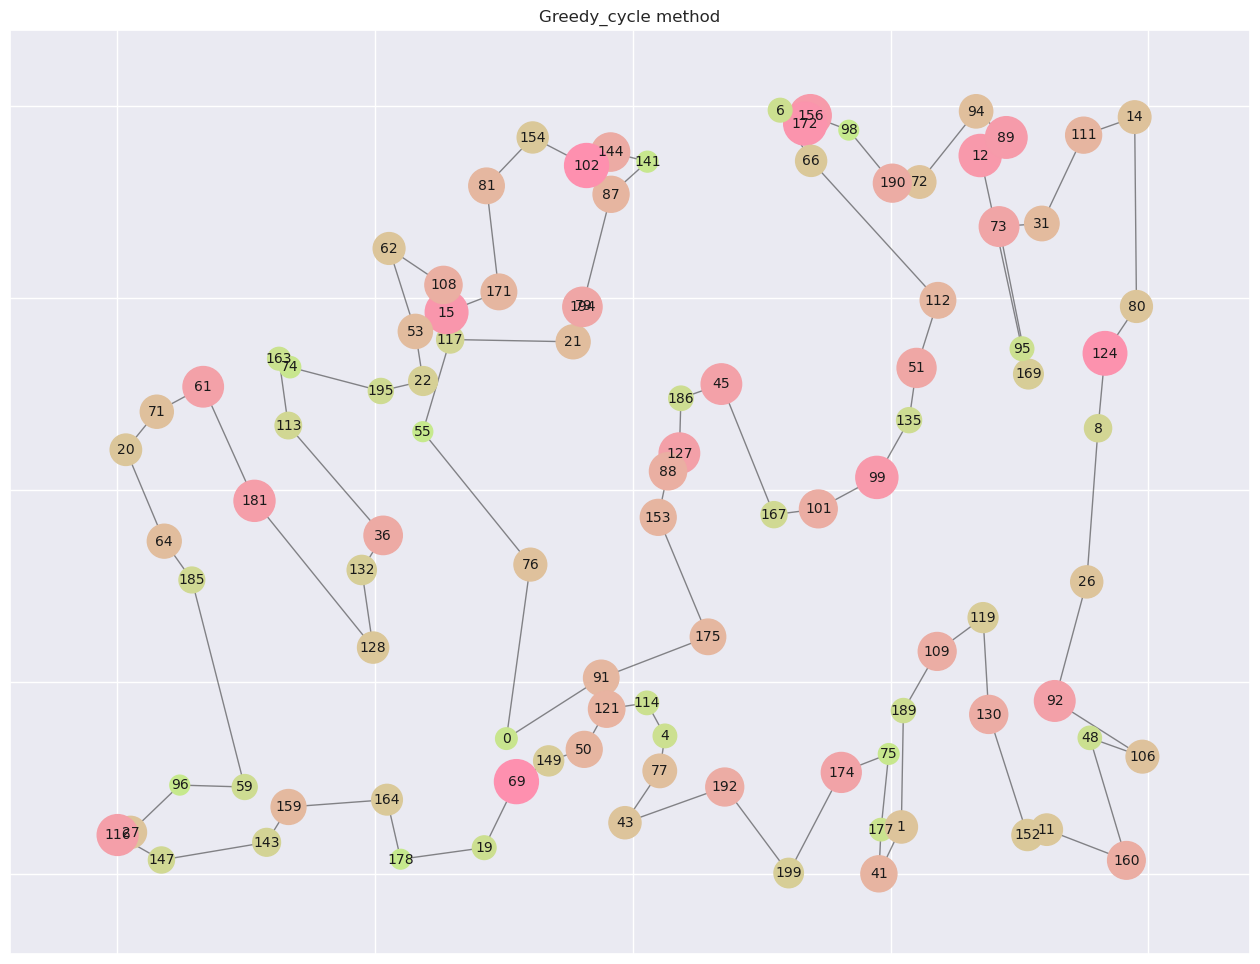

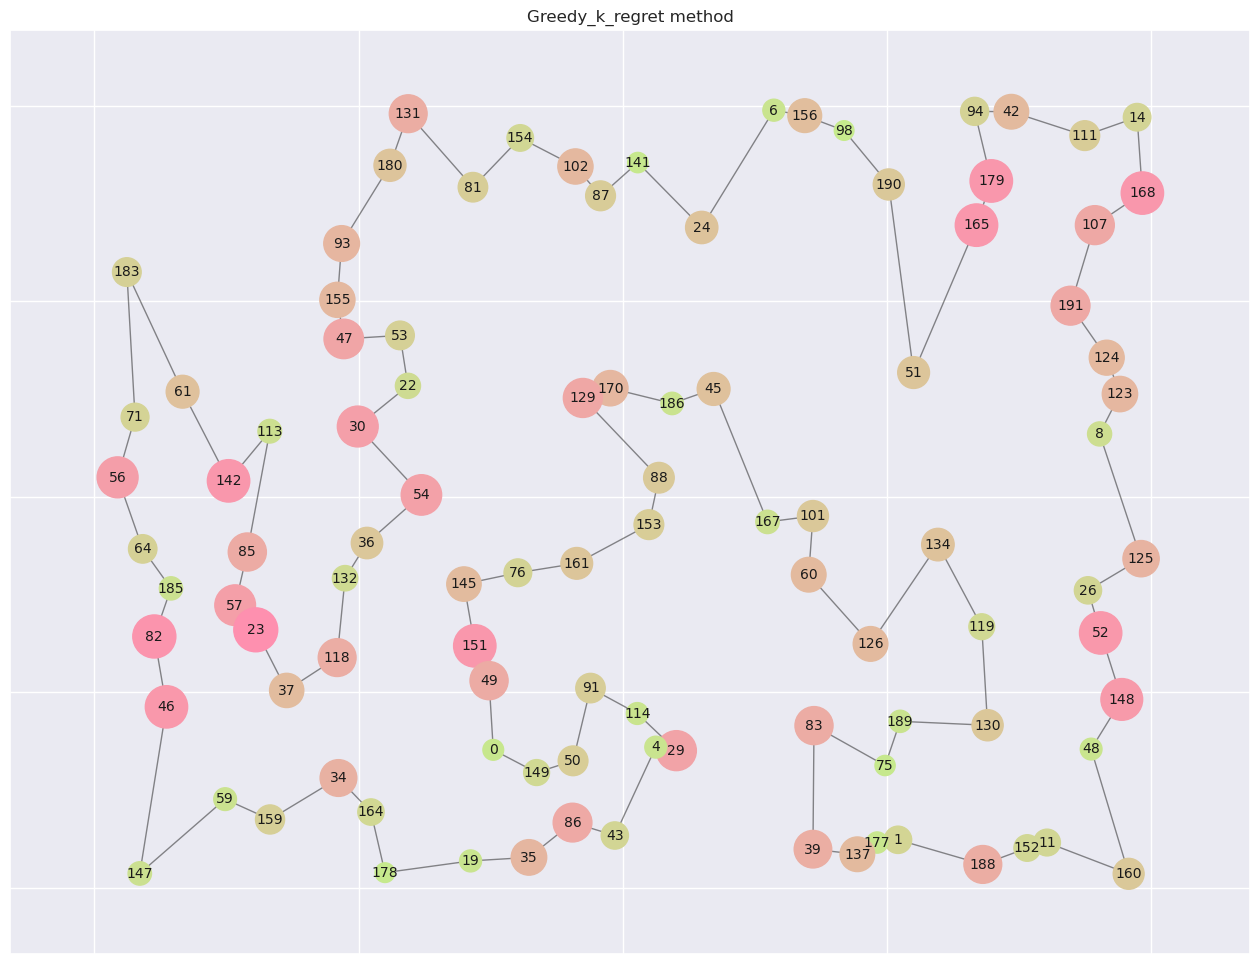

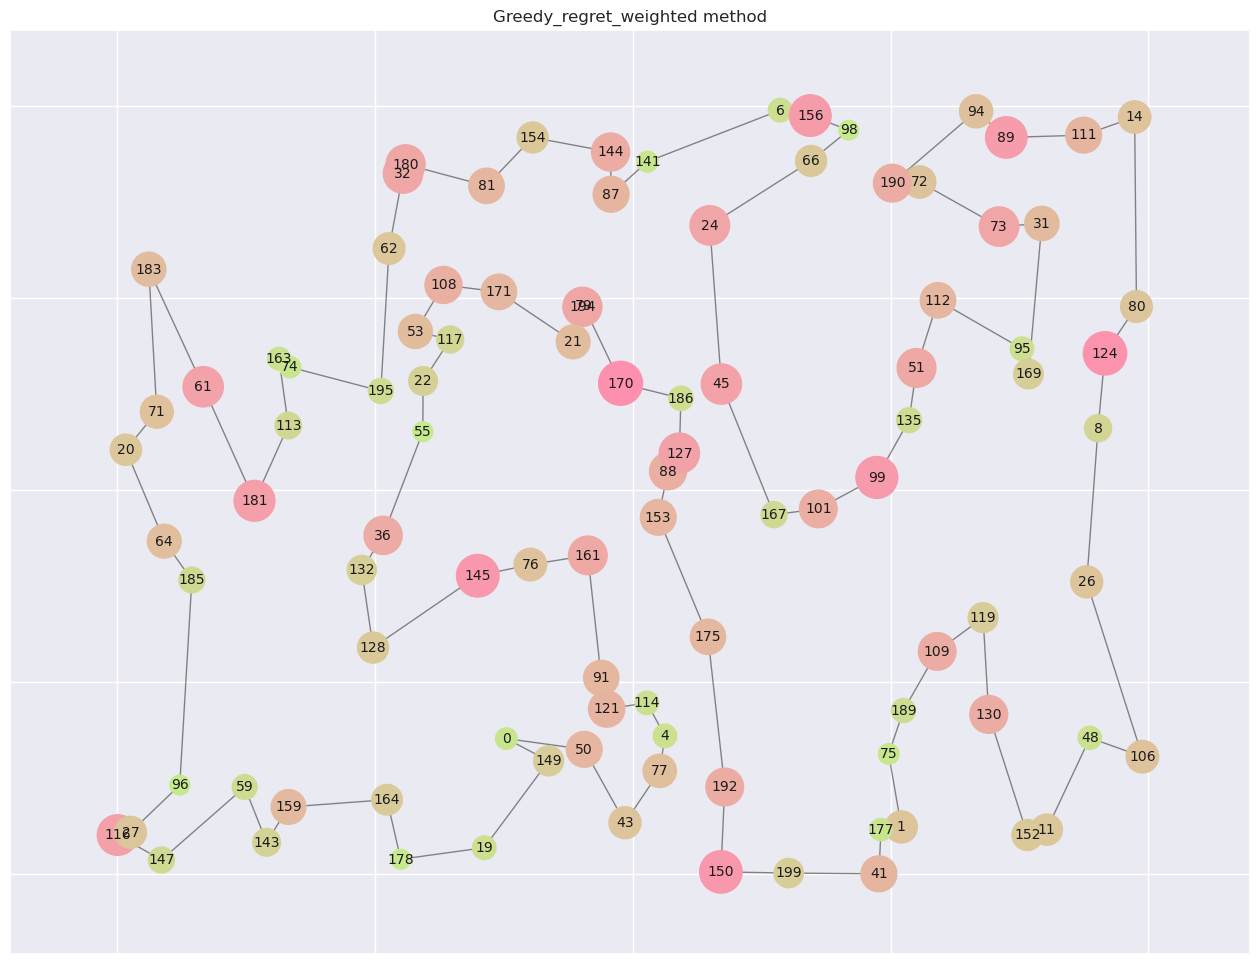

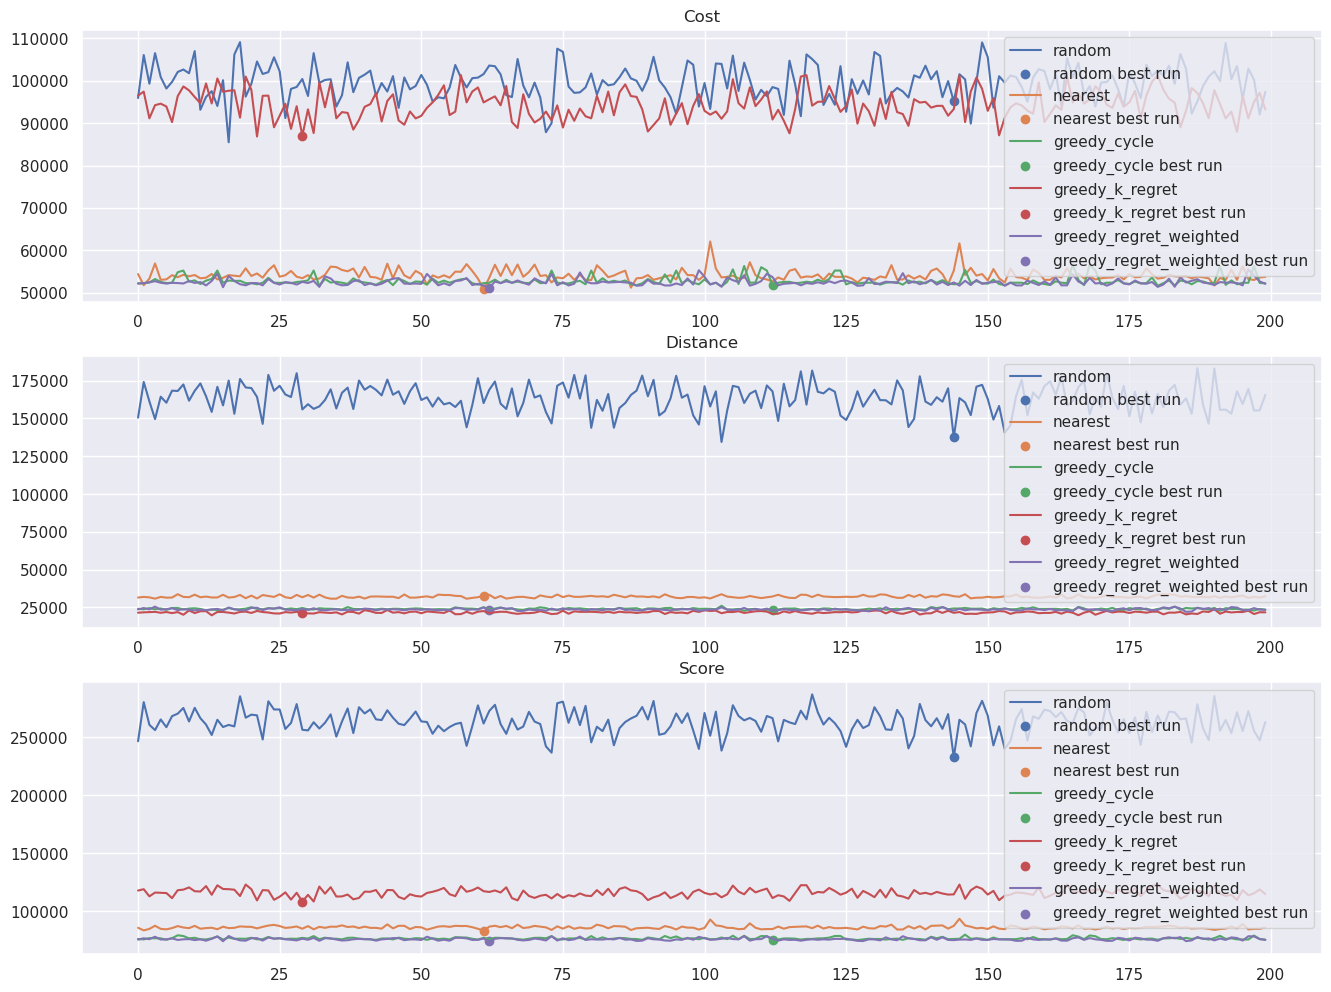

In [17]:
grade_dataset(df_a)

Running random method for 200 runs
Finished random method in 0.26s
Running nearest method for 200 runs
Finished nearest method in 1.10s
Running greedy_cycle method for 200 runs
Finished greedy_cycle method in 79.51s
Running greedy_k_regret method for 200 runs
Finished greedy_k_regret method in 64.40s
Running greedy_regret_weighted method for 200 runs
Finished greedy_regret_weighted method in 65.13s

==================================== Grade =====================================
Method:                                 random
Best run id:                            107
Best run cost:                          93856
Best run distance:                      142060
Best run score:                         235916
Min score:                              235916
Avg score:                              264569
Max score:                              290222


==================================== Grade =====================================
Method:                                 nearest
Best run id: 

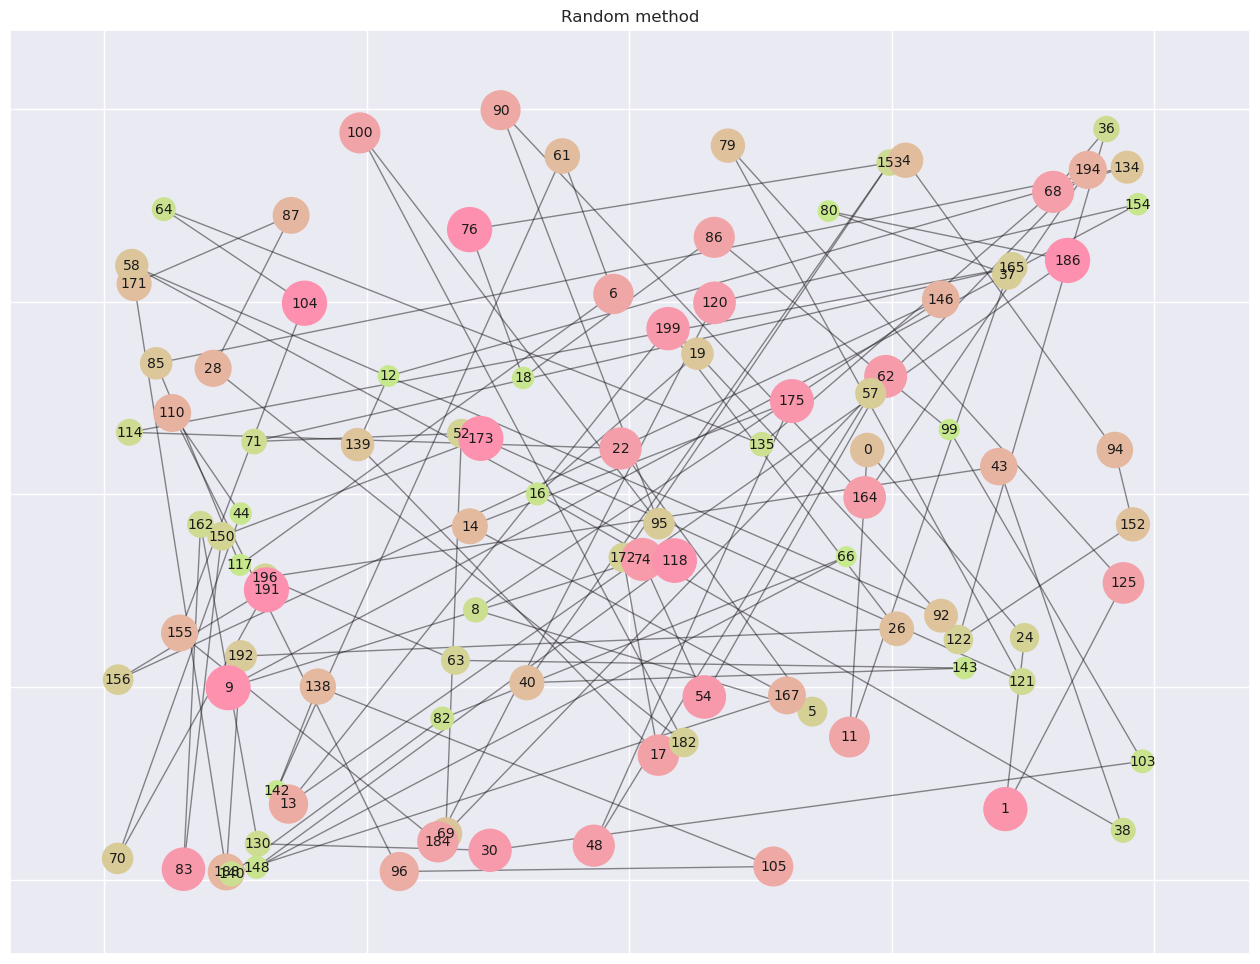

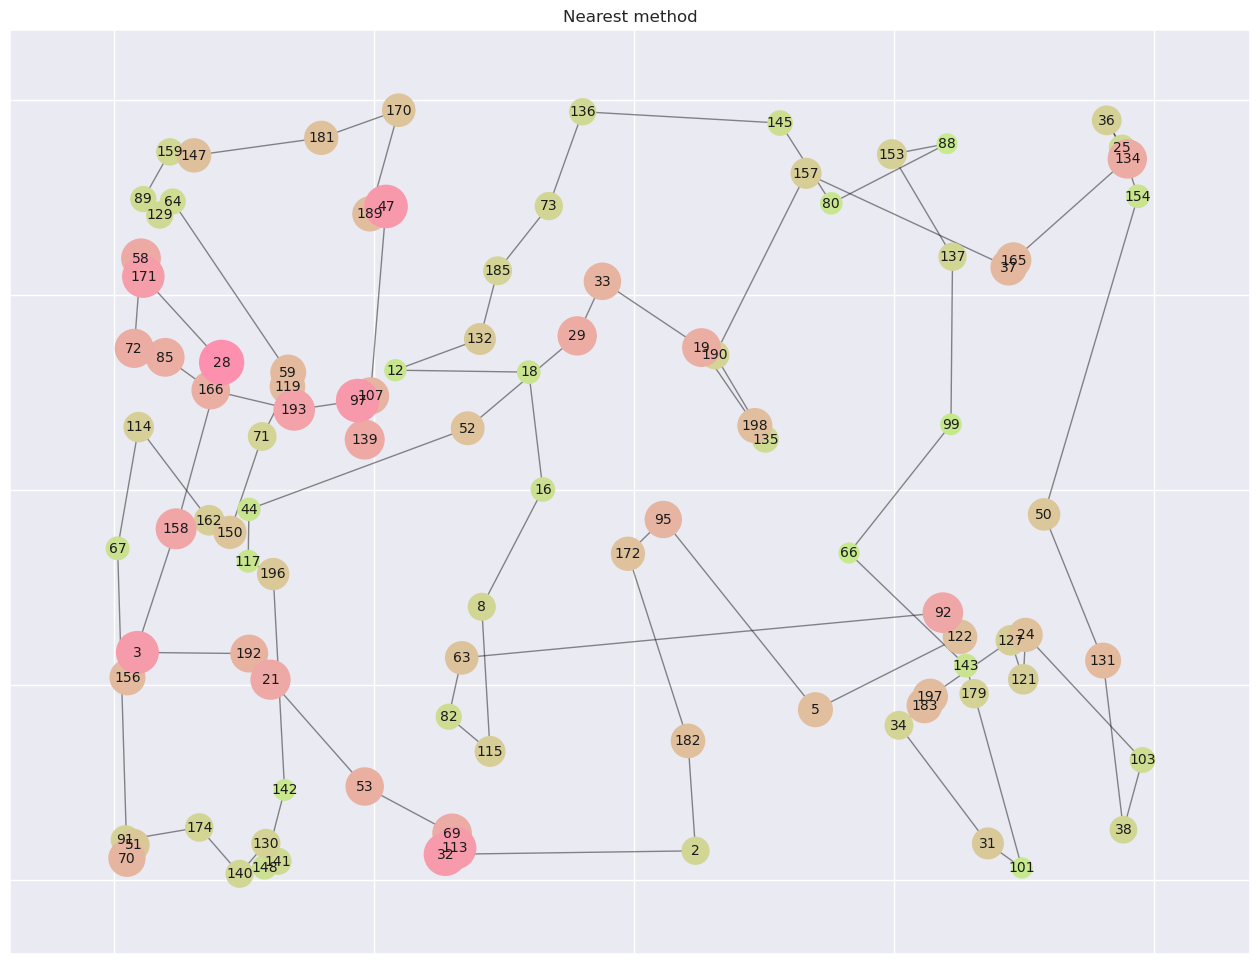

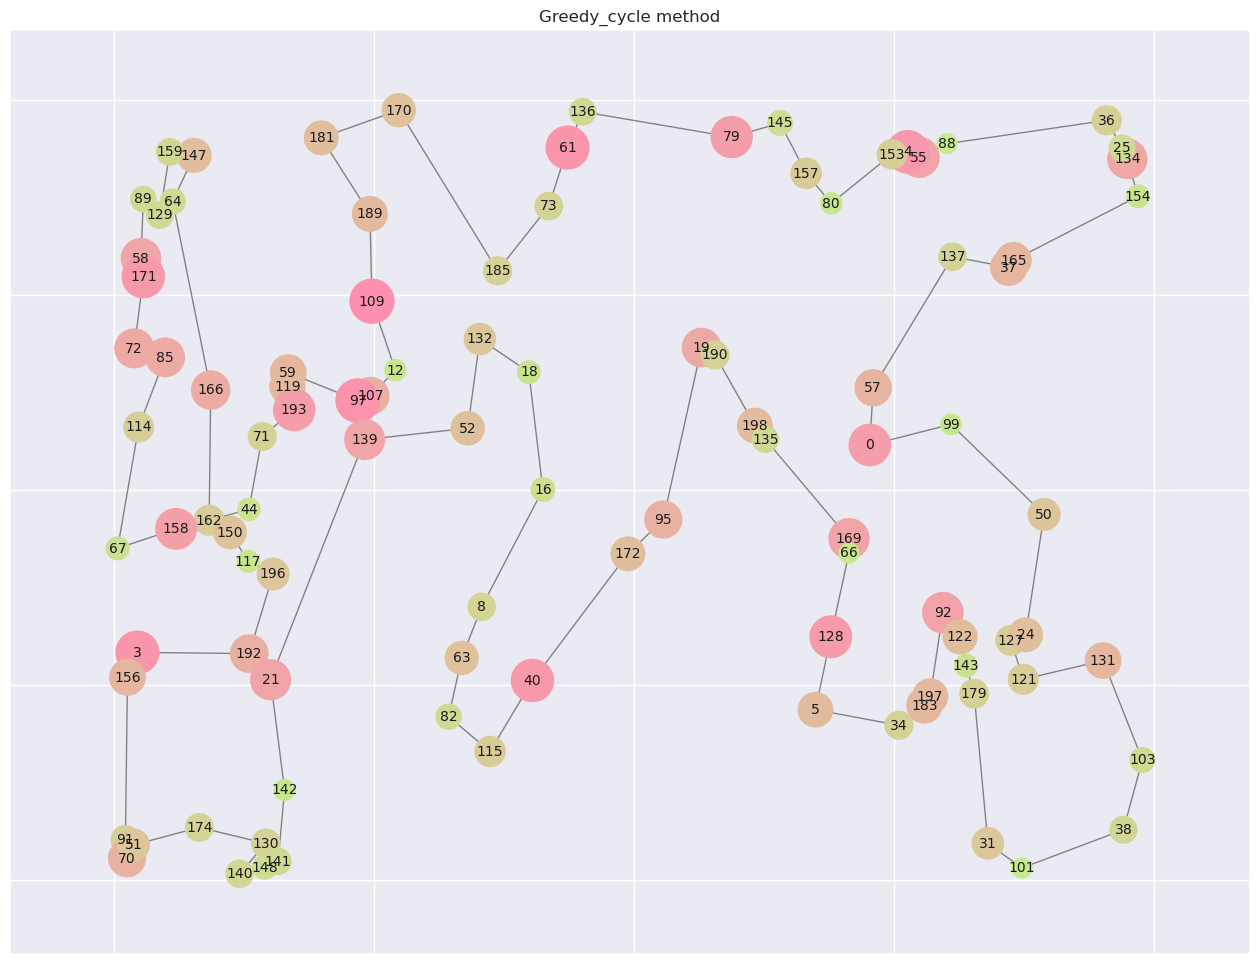

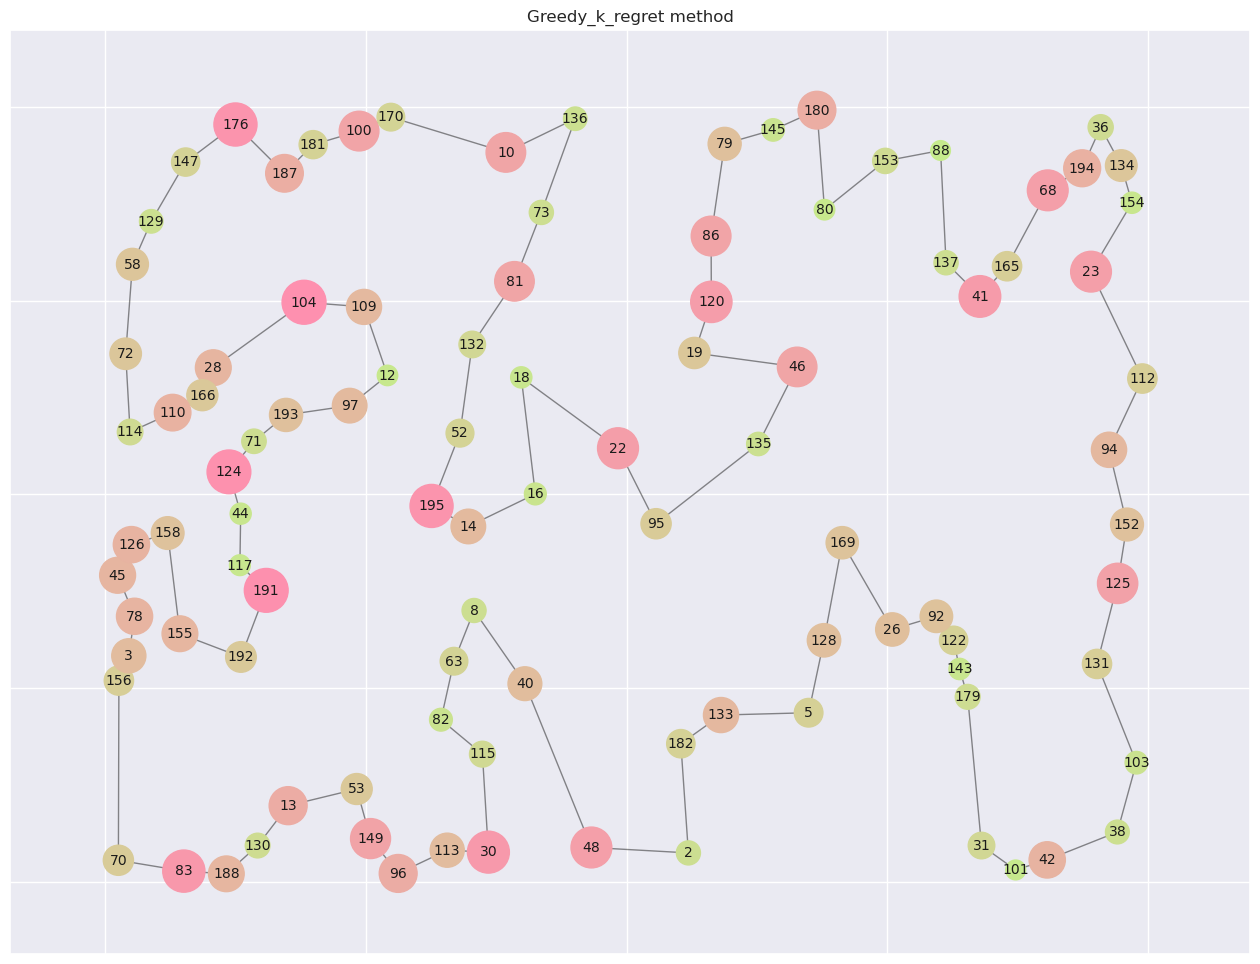

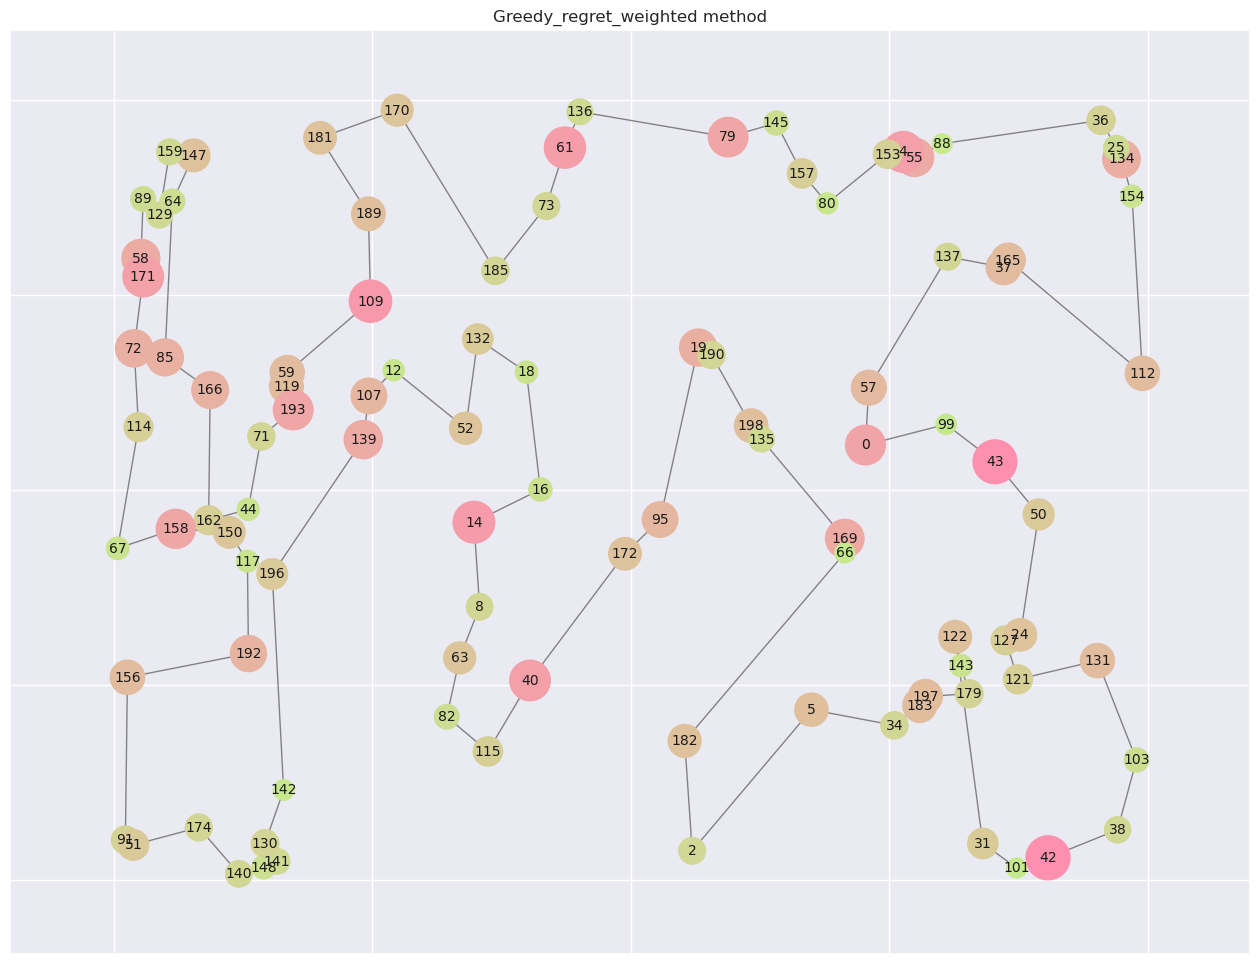

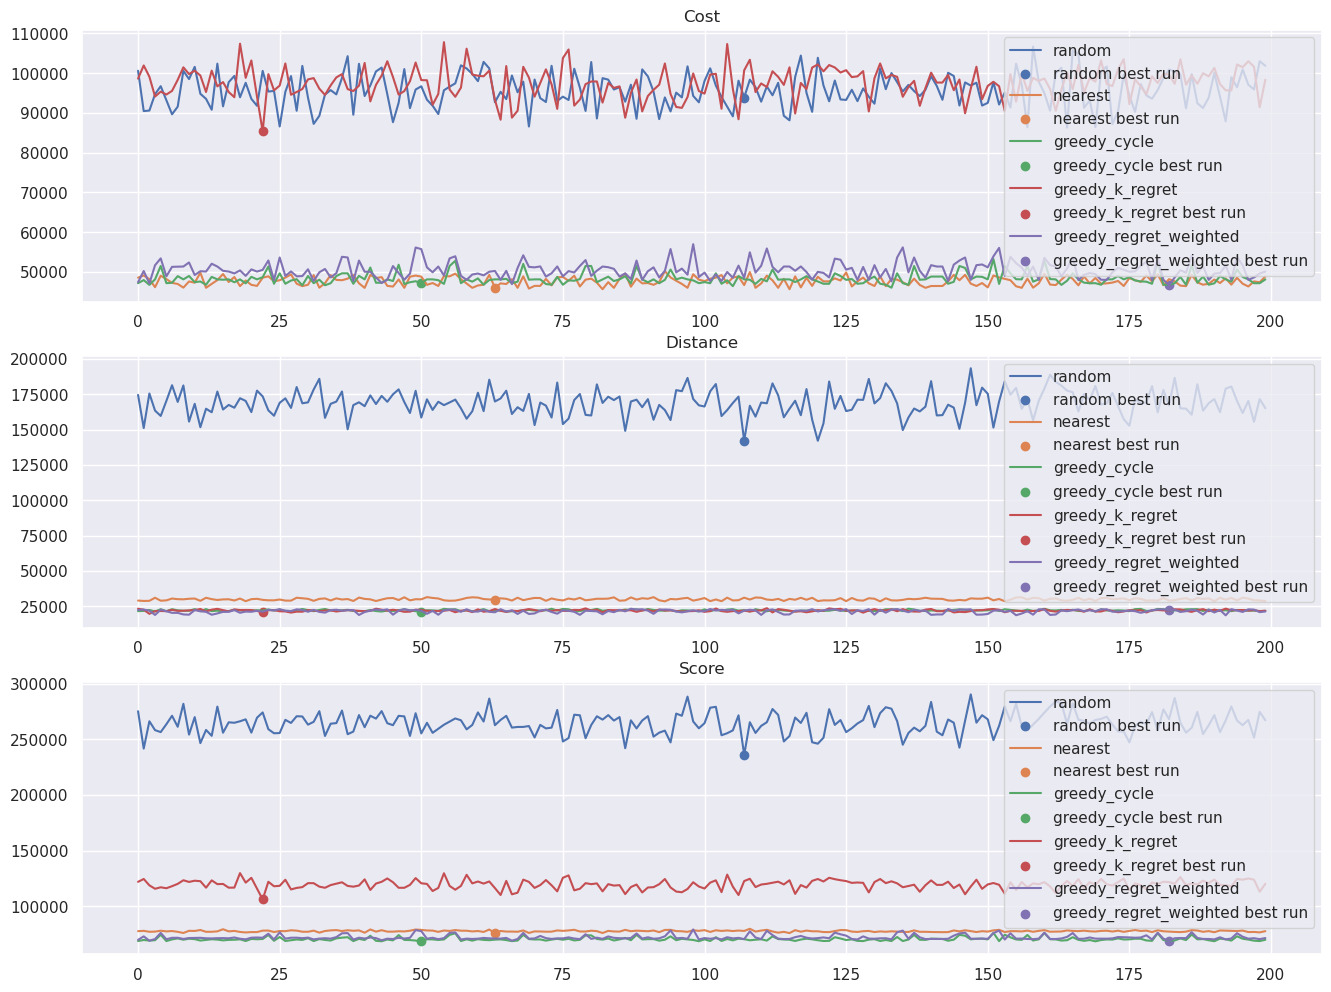

In [18]:
grade_dataset(df_b)

As we can see from aforementioned graphs and tables the `greedy_cycle` methods for both datasets (TSPA and TSPB) have best scores out of all approaches (with one exception). 

The `random` one is once again the worst one. This time the second worst one is `greedy_cycle_k_regret` (here with k=2) method. It performs poorly, worse than the `nearest_neighbour` method. The best methods are `greedy_cycle` (basic version) and `greedy_cycle_weighted` (weights are equal for both regrets and for the delta change). Both of them have very similar scores and runtimes (`greedy_cycle` has a bit longer runtime but it's caused by implementation details).

Out of all tested methods though in our opinion if we take into consideration both runtime and score the `nearest_neighbour` method is winning with around 60x speedup and only ~8% worse score.